<a href="https://colab.research.google.com/github/victor-radermecker/Capstone_JPMorgan/blob/conv-lstm/Notebooks-Colab/ConvLSTM_XGB-Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvLSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Import packages
import sys
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set preferences
tf.random.set_seed(42)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# update local libraries automatically
%load_ext autoreload
%autoreload 2

# Predicting Urbanization *Rate* Using Convolutional LSTMs

`Author:` Andrea Zanon, Victor Radermecker

`Date:` Tuesday, July 18th

In this Jupyter Notebook, we predict urbanization rate using a Convolution Long Short Term Memory model. The training data consists of Dynamic World labels, extracted using the Fishnet Class.

_Data Loading_:

A CSV of the following structure should be loaded to run the following model. This dataframe can be obtained using the `DataPreprocessing.ipynb` file from the package. This Notebook requires having a `Fishnet` object that be generated using the `DataExporter.py` and `DataPreprocessing.py`. Each .CSV dataset comes with a metadata .txt file, that contains useful information such as the number of rows and columns in the fishnet. These values are necessary to run this Notebook. The second cell below prints the information contains in the metadata file.

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<table>
  <thead>
    <tr>
      <th>idx</th>
      <th>tile_id</th>
      <th>batch_id</th>
      <th>year</th>
      <th>urbanization_rate</th>
      <th>urbanization</th>
      <th>Lat</th>
      <th>Lon</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2017</td>
      <td>0.063333</td>
      <td>0.710556</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>1</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2018</td>
      <td>0.097778</td>
      <td>0.773889</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>2</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2019</td>
      <td>-0.010556</td>
      <td>0.871667</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>3</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2020</td>
      <td>0.025000</td>
      <td>0.861111</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>4</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2021</td>
      <td>0.027778</td>
      <td>0.886111</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
  </tbody>
</table>


In [7]:
# train data, Texas region
train_data = pd.read_csv('/content/drive/MyDrive/Code/Datasets/Train/urbanization_train.csv')

In [ ]:
# validation data, Georgia region
val_data = pd.read_csv('/content/drive/MyDrive/Code/Datasets/Valid/urbanization_valid.csv') # change

In [ ]:
# test data, Ohio region
# test_data = pd.read_csv('/content/drive/MyDrive/Code/Datasets/Test/urbanization_test.csv') # change

# Tensor Generation

In [ ]:
def generate_tensor(data, rows, cols, years):
  tensor = np.zeros((len(years), rows, cols, 1))

  for yr in years:
      tensor[years.index(yr), :, :, 0] = data[data["year"]== yr]["urbanization_rate"].to_numpy().reshape(rows, cols)

  return tensor

In [ ]:
# Generate tensor
years = [2017, 2018, 2019, 2020, 2021, 2022]

train_rows = 606
train_cols = 1205
train_tensor = generate_tensor(train_data, train_rows, train_cols, years)
print("train shape: ", train_tensor.shape)
val_rows = 443
val_cols = 743
val_tensor = generate_tensor(val_data, val_rows, val_cols, years)
print("val shape: ", val_tensor.shape)

train shape:  (6, 606, 1205, 1)
val shape:  (6, 443, 743, 1)


# Data Visualization

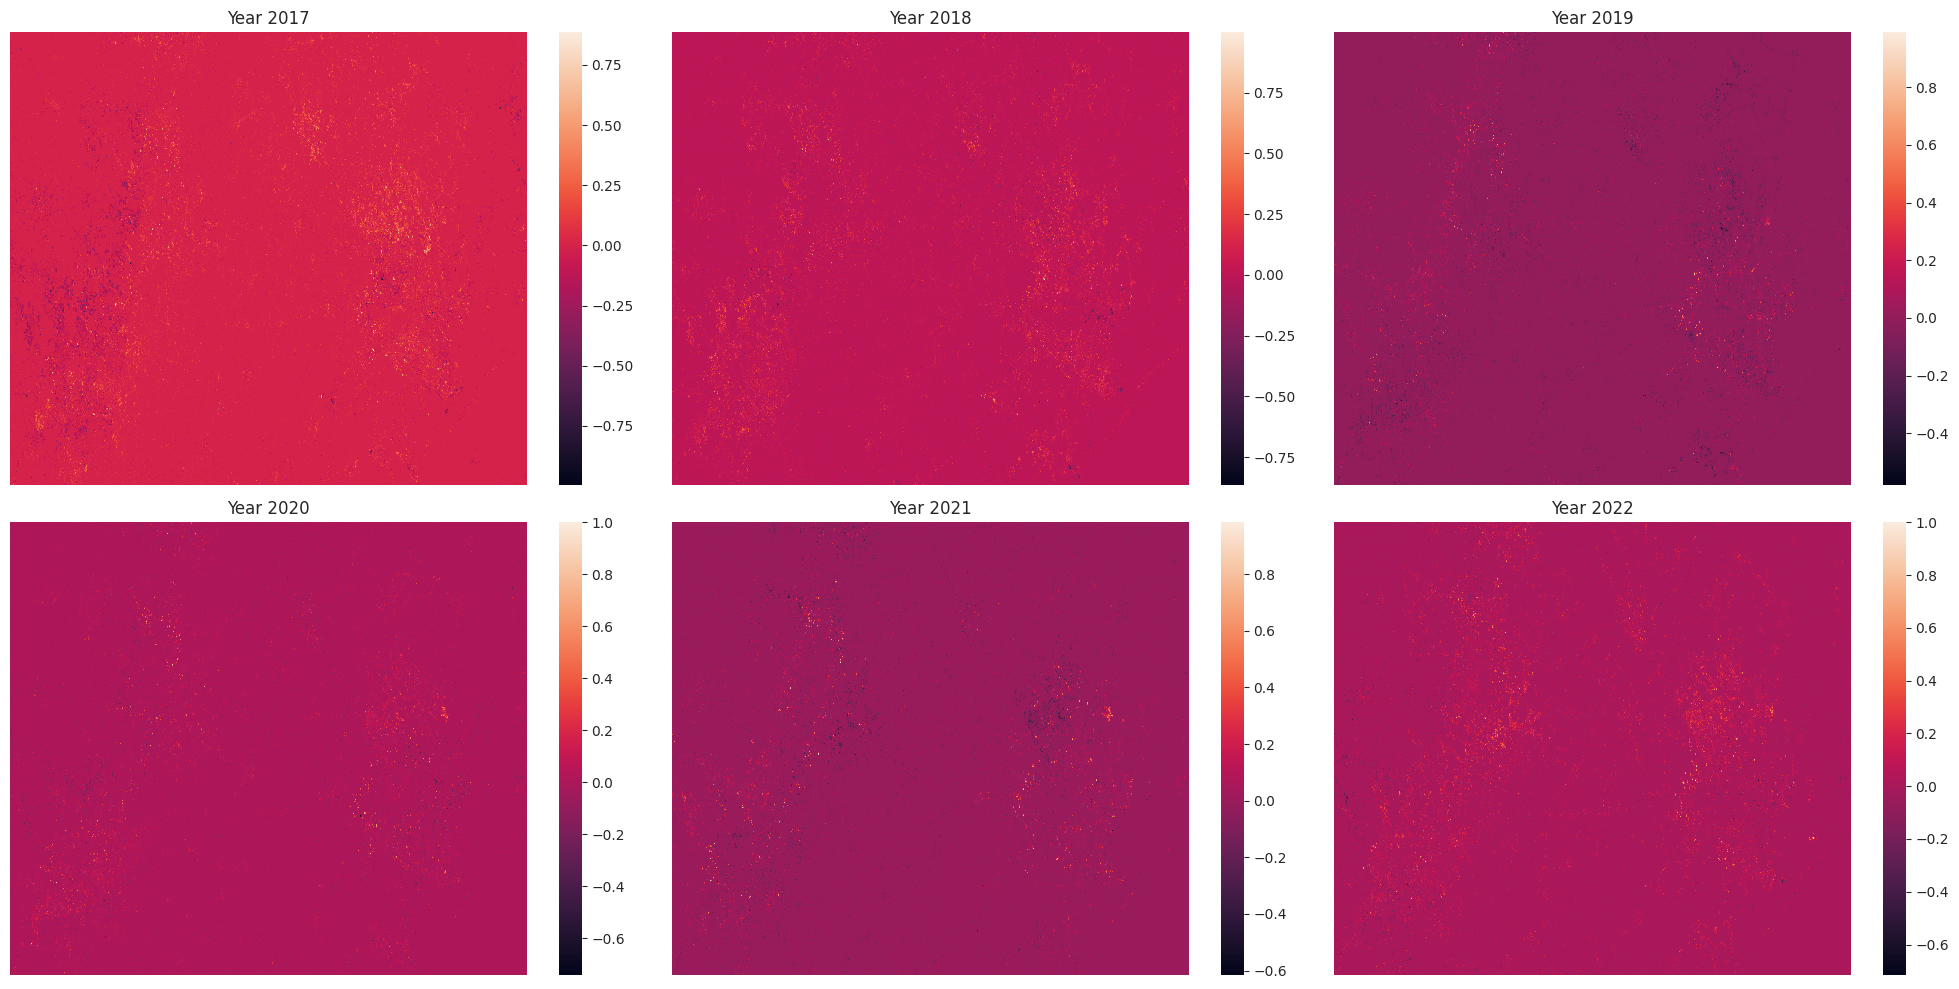

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):
    # Plot the heatmap
    sns.heatmap(train_tensor[i, :, :, 0], ax=ax[i//3, i%3], cmap='rocket')
    ax[i//3, i%3].set_title(f"Year {years[i]}")
    ax[i//3, i%3].set_xticks([])
    ax[i//3, i%3].set_yticks([])
plt.tight_layout()
plt.show()

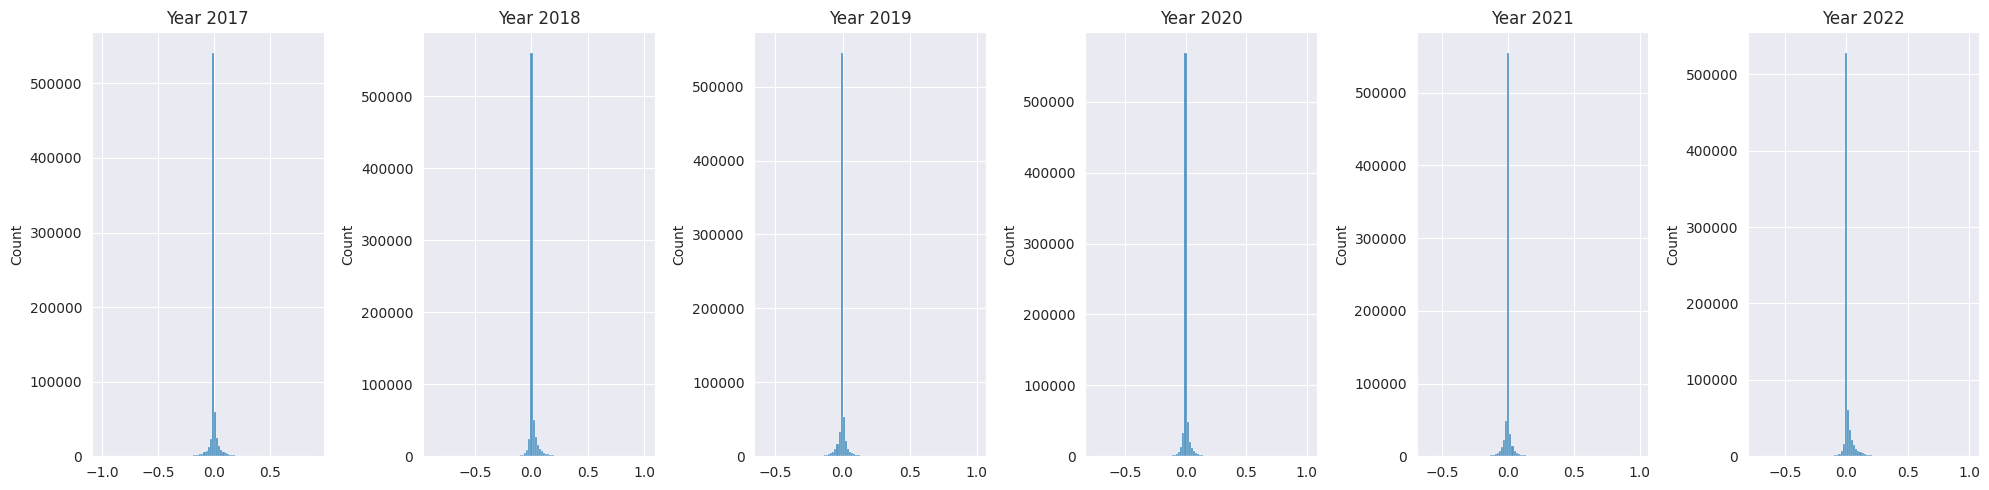

In [ ]:
# plot the urbanization rate histogram seaborn

fig, ax = plt.subplots(1, 6, figsize=(20, 5))
for i in range(6):
    sns.histplot(train_tensor[i, :, :, 0].flatten(), ax=ax[i], bins=100)
    ax[i].set_title(f"Year {years[i]}")
    plt.tight_layout()

# Training Dataset Generation

Now, we need to generate the dataset. Therefore, we will define a data loader. We need to generate a dataset having the following dimensions:

`(NBR_SAMPLES, TIME_SEQ, IMG_WIDTH, IMG_HEIGHT, CHANNELS)`

In [ ]:
def extract_submatrix(matrix, length, slide_size):
    """
    Extracts overlapping submatrices of a specified length from a given 2D matrix.

    Parameters:
        matrix (numpy.ndarray): The input 2D matrix from which submatrices will be extracted.
        length (int): The side length of the submatrices to be extracted.
        slide_size (int): The step size for sliding the extraction window.

    Returns:
        numpy.ndarray: An array containing the extracted submatrices as its elements.
    """
    submatrices = []
    rows, cols = matrix.shape
    for i in range(0, rows - (length - 1), slide_size):
        for j in range(0, cols - (length - 1), slide_size):
            submatrix = matrix[i:i+length, j:j+length]
            submatrices.append(submatrix)
    return np.array(submatrices)

def generate_submatrices(tensor, years, length, slide_size):
    """
    Generates overlapping submatrices from a 4D tensor, representing data for multiple years.

    Parameters:
        tensor (numpy.ndarray): The 4D tensor containing data for multiple years, where the first dimension
                                represents the year, and the other dimensions represent the spatial data.
        years (list): A list of year values corresponding to each data slice along the first dimension of tensor.
        length (int): The side length of the submatrices to be extracted.
        slide_size (int): The step size for sliding the extraction window.

    Returns:
        numpy.ndarray: An array containing the generated submatrices as its elements.
    """
    submatrices = []
    for i, yr in enumerate(years):
        mat = tensor[i, :, :, 0]
        submatrices.append(extract_submatrix(mat, length, slide_size))
    submatrices = np.array(submatrices)
    transposed_array = np.transpose(submatrices, (1, 0, 2, 3))
    reshaped_array = transposed_array.reshape((-1, len(years), length, length, 1))
    return reshaped_array

In [ ]:
TIME_SEQ = 6  # frames
IMG_SIZE = 15  # tiles
SLIDE_WDW = 5 # tiles
years = ["2017", "2018", "2019", "2020", "2021", "2022"]

train_sub_matrices = generate_submatrices(train_tensor, years, IMG_SIZE, SLIDE_WDW)
val_sub_matrices = generate_submatrices(val_tensor, years, IMG_SIZE, SLIDE_WDW)

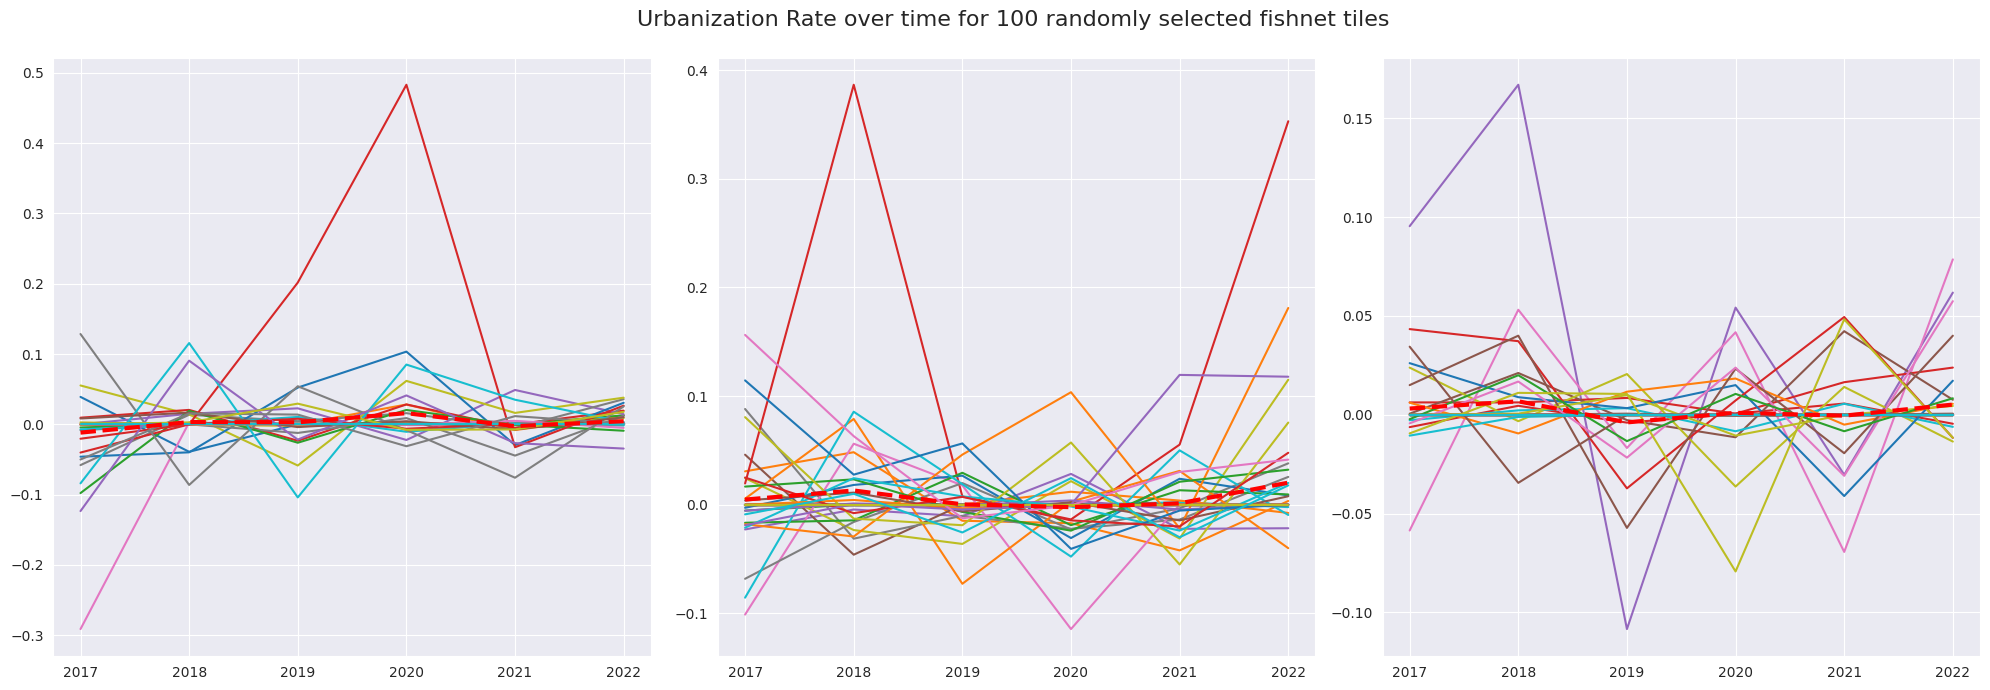

In [ ]:
# Plot the yearly urbanization for 100 different tile_ids randomly selected
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
for subplot in ax:
    for _ in range(50):
        tile_id = np.random.choice(train_data["tile_id"].unique())
        subplot.plot(train_data[train_data["tile_id"]==tile_id]["year"], train_data[train_data["tile_id"]==tile_id]["urbanization_rate"])

    # title for the whole
    ax[1].set_title("Urbanization Rate over time for 100 randomly selected fishnet tiles \n", fontsize=16, loc="center")

    # Calculate and plot the average line
    avg_line = np.mean([line.get_ydata() for line in subplot.lines], axis=0)
    subplot.plot(train_data[train_data["tile_id"]==tile_id]["year"], avg_line, color="red", linestyle="--", label="Average", linewidth=3)

# plt.title("Urbanization over time for 100 randomly selected fishnet tiles", fontsize=16, loc="left")
plt.tight_layout()
plt.show()


Displaying frames for example 9370.


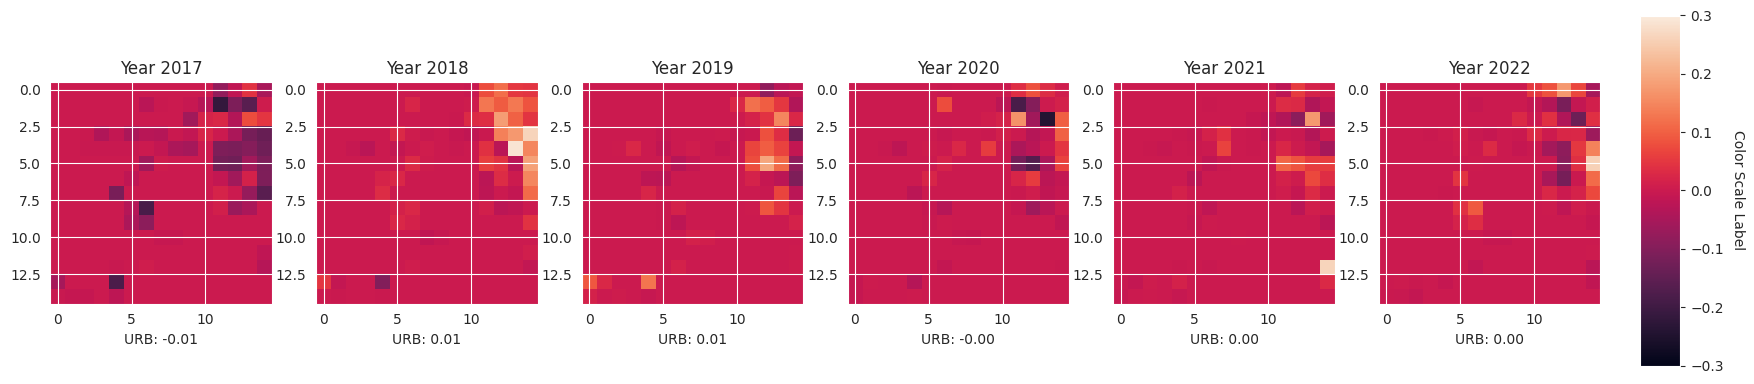

In [ ]:
nbr_years = len(years)
min_val = -0.3
max_val = 0.3

fig, axes = plt.subplots(1, nbr_years, figsize=(20, 5))
data_choice = np.random.choice(range(len(train_sub_matrices)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    im = ax.imshow(np.squeeze(train_sub_matrices[data_choice][idx]), cmap="rocket", vmin=min_val, vmax=max_val)
    ax.set_title(f"Year {years[idx]}")
    ax.set_xlabel(f"URB: {np.mean(train_sub_matrices[data_choice][idx]):.2f}")
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size of the colorbar
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Color Scale Label', rotation=270, labelpad=15)

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()


# Generate the training dataset

In [ ]:
def generate_shited_frames(data, type, n_frames):
    shape = data.shape
    x = data[:, 0 : n_frames, :, :]
    y = data[:, n_frames, :, :]
    for i in range(1, shape[1] - n_frames):
      x = np.concatenate((x, data[:, i : i + n_frames, :, :]), axis = 0)
      y = np.concatenate((y, data[:, n_frames, :, :]), axis = 0).reshape((data.shape[0]*2,1, data.shape[2], data.shape[3], data.shape[4]))

    return x, y

# Apply the processing function to the datasets.
n_frames = 4 # how many frames used to predict
x_train, y_train = generate_shited_frames(train_sub_matrices, "train", n_frames)
x_val, y_val = generate_shited_frames(val_sub_matrices, "validation", n_frames)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (56882, 4, 15, 15, 1), (56882, 1, 15, 15, 1)
Validation Dataset Shapes: (25112, 4, 15, 15, 1), (25112, 1, 15, 15, 1)


### Filter the training dataset

As shown before, we have a massive amount of tiles with a *null* urbanization. We want to discard these inputs to void polluting the training with black/nearly black image sequesnces. In practice, as we will show this means that we are mostly training the CNN around urbanized areas (like cities). For the other areas, another model will have to be trained later.

Therefore, we want to keep only the sequences having an urbanization rate in year 3 outside [-X, X].

- `How do we define X?`
0.01 (1% urbanization variations)

In [ ]:
def filter_data(X, threshold, years):
    if years == "last":
        mask = np.abs(X[:, -1, :, :, 0].mean(axis=(1, 2))) > threshold
    elif years == "avg":
        mean_across_years = X.mean(axis=1)
        mask = np.abs(mean_across_years[:, :, :, 0]).mean(axis=(1, 2)) > threshold
    else:
        raise ValueError("Years must be in last or avg")
    labels = np.where(mask, "train", "skip")
    return labels, mask

def merge_lists(train_skip_list, y_pred_f, y_pred_s):
    """
    Merge predictions from two lists based on a train_skip_list.

    This function takes three inputs: 'train_skip_list', 'y_pred_f', and 'y_pred_s'.

    Parameters:
    train_skip_list (list): A list of strings representing the actions for merging the predictions.
                            Each element of the list can be either 'train' or 'skip'.
                            'train' indicates taking the prediction from 'y_pred_f',
                            and 'skip' indicates taking the prediction from 'y_pred_s'.

    y_pred_f (numpy.ndarray): A 3D numpy array containing predictions for 'train' samples.
                              The shape should be (num_train, height, width).

    y_pred_s (numpy.ndarray): A 3D numpy array containing predictions for 'skip' samples.
                              The shape should be (num_skip, height, width).

    Returns:
    numpy.ndarray: A 3D numpy array containing the merged predictions based on 'train_skip_list'.
                   The shape will be (num_merged, height, width).
    """
    idx_f = 0
    idx_s = 0
    merged_list = []
    dim = y_pred_f.shape[1:]

    for item in train_skip_list:
        if item == 'train':
            merged_list.append(y_pred_f[idx_f].reshape(dim))
            idx_f += 1
        elif item == 'skip':
            merged_list.append(y_pred_s[idx_s].reshape(dim))
            idx_s += 1

    return np.array(merged_list)

We will be excluding all points that have an average urbanization rate lower than `THRESHOLD` using the `filter_data` function above. We will only train the Conv-LSTM on the training points. For the points outside urban areas, we will simply predict weros. Later, we will use the `merge_lists` function to merge the Conv-LSTM results (`y_pred_f`) with the zeros generate (`y_pred_s`).

In [ ]:
THRESHOLD = 0.005
method = "last" #"avg"

train_idx, train_mask = filter_data(x_train, THRESHOLD, "last")
x_train_f, y_train_f = x_train[train_mask], y_train[train_mask]
x_train_s, y_train_s = x_train[~train_mask], y_train[~train_mask]

val_idx, val_mask = filter_data(x_val, THRESHOLD, "last")
x_val_f, y_val_f = x_val[val_mask], y_val[val_mask]
x_val_s, y_val_s = x_val[~val_mask], y_val[~val_mask]

In [ ]:
train_idx

array(['skip', 'skip', 'skip', ..., 'skip', 'skip', 'skip'], dtype='<U5')

As a recall, the points used to train, will be:

- x_train_f
- y_train_f

And the validation dataset will be:
- x_val_f
- y_val_f

Find the dimensions below.

In [ ]:
print(x_train_f.shape)
print(y_train_f.shape)

print(x_train_s.shape)
print(y_train_s.shape)

print(x_val_f.shape)
print(y_val_f.shape)

print(x_val_s.shape)
print(y_val_s.shape)

(15868, 4, 15, 15, 1)
(15868, 1, 15, 15, 1)
(41014, 4, 15, 15, 1)
(41014, 1, 15, 15, 1)
(11844, 4, 15, 15, 1)
(11844, 1, 15, 15, 1)
(13268, 4, 15, 15, 1)
(13268, 1, 15, 15, 1)


In [ ]:
# Create a Keras input dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_f, y_train_f))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_f, y_val_f))

In [ ]:
# How to get one pair (X,y) ?
train_iter = iter(train_dataset)
x, y = next(train_iter)
print(x.shape)
print(y.shape)

(4, 15, 15, 1)
(1, 15, 15, 1)


# Data Augmentation

We will apply the following data augmentation to increase the size of our dataset.

1. Rotation (90, 180 and 270 degrees)

2. Vertical and Horizontal Symmetries

In [ ]:
def rotate_image(image, k):
    return tf.image.rot90(image, k)

def augment(x, y):
    # Random rotation between -90 and 180 degrees
    k = np.random.choice([-1, 0, 1, 2])
    x_aug = tf.map_fn(lambda image: rotate_image(image, k), x)
    y_aug = tf.map_fn(lambda image: rotate_image(image, k), y)

    # Horizontal flip
    l = np.random.choice([0, 1])
    if l == 0:
        x_aug = tf.image.flip_left_right(x_aug)
        y_aug = tf.image.flip_left_right(y_aug)

    # Vertical flip
    m = np.random.choice([0, 1])
    if m == 0:
        x_aug = tf.image.flip_up_down(x_aug)
        y_aug = tf.image.flip_up_down(y_aug)

    return x_aug, y_aug

In [ ]:
train_iter = iter(train_dataset)
X, y = next(train_iter)
X_aug, y_aug = augment(X, y)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
aug_train_dataset = train_dataset.map(lambda x, y: (augment(x, y)),
                num_parallel_calls=AUTOTUNE)

# Visualize the data augmentation

In [ ]:
def plot_seq(x,y):
    TIME_SEQ = x.shape[0]
    fig, axes = plt.subplots(1, TIME_SEQ+1, figsize=(10, 4))
    for i in range(TIME_SEQ):
        axes[i].imshow(x[i, :, :, 0], cmap='gray')
    axes[TIME_SEQ].imshow(y[0, :, :, 0], cmap='gray')
    plt.tight_layout()

def plot_seq_aug(x, y, x_aug, y_aug):
    TIME_SEQ = x.shape[0]
    fig, axes = plt.subplots(2, TIME_SEQ+1, figsize=(10, 4))
    for i in range(TIME_SEQ):
        axes[0, i].imshow(x[i, :, :, 0], cmap='gray')
        axes[1, i].imshow(x_aug[i, :, :, 0], cmap='gray')

    axes[0, TIME_SEQ].imshow(y[0, :, :, 0], cmap='gray')
    axes[1, TIME_SEQ].imshow(y_aug[0, :, :, 0], cmap='gray')

    # add titles to each subrow
    axes[0, 2].set_title('Original')
    axes[1, 2].set_title('Augmented')
    plt.tight_layout()


In [ ]:
train_iter = iter(train_dataset)
aug_train_iter = iter(aug_train_dataset)

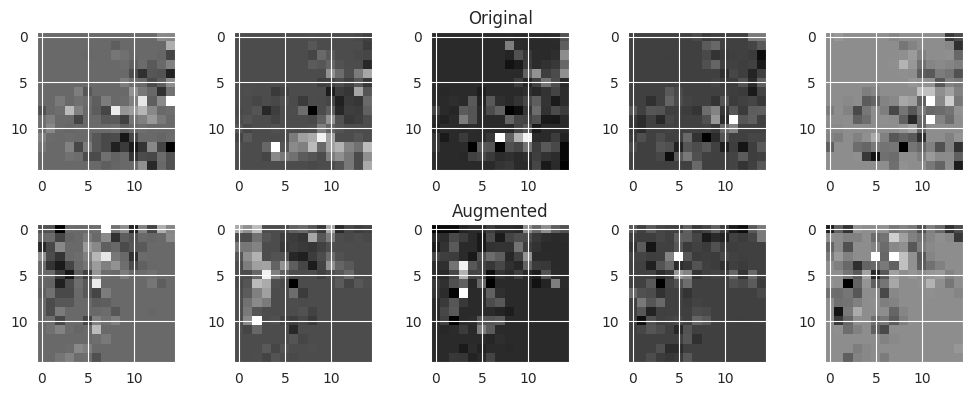

In [ ]:
# get a random element from train_dataset
x, y = next(train_iter)
x_aug, y_aug = next(aug_train_iter)

plot_seq_aug(x, y, x_aug, y_aug)

# Training the model

## Prepare the data

In [ ]:
def prepare(ds, batch_size, shuffle=False, augment=None):

    # Augment data
    if shuffle:
        ds = ds.shuffle(1000)

    # Apply mapping function
    if augment is not None:
        # ds_aug = ds.map(lambda x, y: augment(x, y),
        #         num_parallel_calls=AUTOTUNE)
        ds_aug = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.concatenate(ds_aug)

    # Batch all datasets.
    ds = ds.batch(batch_size)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
batch_size = 64

train_ds = prepare(train_dataset, batch_size, shuffle=True, augment=augment)
val_ds = prepare(val_dataset, batch_size)

In [ ]:
def create_model():
    # Construct the input layer with 4 time frames in input
    inp = layers.Input(shape=(4, *x_train.shape[2:]))

    # We will construct 3 `ConvLSTM2D` layers with batch normalization,
    # followed by a `Conv3D` layer for the spatiotemporal outputs.
    x = layers.ConvLSTM2D(
        filters=64,                # transform each image into a 64 channel image
        kernel_size=(3, 3),        # each image [15,15] --> [13,13] (with 64 channels, see above, filters)
        padding="same",           # valid: no padding (so image stays [5,5], same: padding so image stays [6x6])
        return_sequences=True,
        activation="relu",
    )(inp)
    x = layers.BatchNormalization()(x)   # improve the training speed, stability, and generalization of the network
    x = layers.ConvLSTM2D(
        filters=64,                      #
        kernel_size=(3, 3),              # each previous [5,5] image --> [3,3] image
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(5, 5),
        padding="same",
        return_sequences=False,
        activation="relu",
    )(x)
    x = layers.Conv2D(
        filters=1,               # 1 filter leads to one chanel in the output
        kernel_size=(3, 3),   #
        activation="sigmoid",
        padding="same"
    )(x)

    # Next, we will build the complete model and compile it.
    model = keras.models.Model(inp, x)
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
    return model

# Train the model from scratch
model = create_model()

# Use a pretrained model from HuggingFace (https://huggingface.co/keras-io/conv-lstm)
# model_path = "./pretrained-models/"
# model = tf.keras.models.load_model(model_path)

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Training the model

In [ ]:
# Set tensorboard Callback
log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 200

# Fit the model to the training data.
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[tensorboard_callback],#early_stopping, reduce_lr],
)

# Tensorboard

In [ ]:
# Clear any logs from previous runs
%rm -rf ./logs/

In [ ]:
# command to kill tensorboard process on port 6006: kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
# Run TensorBoard
%reload_ext tensorboard
%tensorboard --logdir=logs

# Make Predictions

In [ ]:
# out-of-sample predictions
y_pred_f = model.predict(x_val_f)
y_pred_s = x_val_s[:,-1,:,:,0]
y_pred = merge_lists(val_idx, y_pred_f, y_val_s)

371/371 [==============================] - 9s 23ms/step


In [ ]:
# in-sample predictions
y_ins_pred_f = model.predict(x_train_f)
y_ins_pred_s = x_train_s[:,-1,:,:,0]
y_ins_pred = merge_lists(val_idx, y_ins_pred_f, y_train_s)

496/496 [==============================] - 12s 24ms/step


Save results for subsequent computation

In [ ]:
# model
model.save('/content/drive/MyDrive/Code/Models/conv-lstm/model')
# arrays
np.save('/content/drive/MyDrive/Code/Models/conv-lstm/predictions/y_pred_val', y_pred)
np.save('/content/drive/MyDrive/Code/Models/conv-lstm/predictions/y_val', y_val)
np.save('/content/drive/MyDrive/Code/Models/conv-lstm/predictions/y_pred_train', y_ins_pred)
np.save('/content/drive/MyDrive/Code/Models/conv-lstm/predictions/y_train', y_train)

# XGBOOST NOTEBOOK

In [ ]:
# load libraries
from collections import Counter
# ALL OTHERS NECESSARY FOR XGB

In this Jupyter Notebook, we predict urbanization rate using an XGBoost model. The training data consists of ConvLSTM urbanization rate predictions, urbanization value in previous years, and geographical location.

_Data Loading_:

Either possible to load the model created on `ConvLSTM.ipynb` _using keras.models.load_model('path/to/location.keras')_, or load the predictions and true values using _np.load(f)_.

In [ ]:
# load model
model = keras.models.load_model('/content/drive/MyDrive/Code/Models/conv-lstm/model')
# load predictions and true values
y_pred = np.load('/content/drive/MyDrive/Code/Models/conv-lstm/predictions/y_pred.npy')
y_val = np.load('/content/drive/MyDrive/Code/Models/conv-lstm/predictions/y_val.npy')
y_ins_pred = np.load('/content/drive/MyDrive/Code/Models/conv-lstm/predictions/y_pred_train')
y_train = np.load('/content/drive/MyDrive/Code/Models/conv-lstm/predictions/y_train')

FileNotFoundError: ignored

Additionally, a CSV of the following structure should be loaded to run the following model. This dataframe can be obtained using the `DataPreprocessing.ipynb` file from the package. This Notebook requires having a `Fishnet` object that be generated using the `DataExporter.py` and `DataPreprocessing.py`. Each .CSV dataset comes with a metadata .txt file, that contains useful information such as the number of rows and columns in the fishnet. These values are necessary to run this Notebook. The second cell below prints the information contains in the metadata file.

<table>
  <thead>
    <tr>
      <th>idx</th>
      <th>tile_id</th>
      <th>batch_id</th>
      <th>year</th>
      <th>urbanization_rate</th>
      <th>urbanization</th>
      <th>Lat</th>
      <th>Lon</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2017</td>
      <td>0.063333</td>
      <td>0.710556</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>1</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2018</td>
      <td>0.097778</td>
      <td>0.773889</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>2</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2019</td>
      <td>-0.010556</td>
      <td>0.871667</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>3</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2020</td>
      <td>0.025000</td>
      <td>0.861111</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>4</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2021</td>
      <td>0.027778</td>
      <td>0.886111</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
  </tbody>
</table>


In [ ]:
# train data, Texas region
train_data = pd.read_csv('/content/drive/MyDrive/Code/Datasets/Train/urbanization_train.csv')

In [ ]:
train_rows = 606
train_cols = 1205

In [ ]:
# read and print a text file
with open('/content/drive/MyDrive/Code/Datasets/Train/urbanization_valid.csv', 'r') as f:
    print(f.read())

In [ ]:
# validation data, Georgia region
val_data = pd.read_csv('/content/drive/MyDrive/Code/Datasets/Valid/urbanization_valid.csv') # change

In [ ]:
val_rows = 443
val_cols = 743

In [ ]:
# test data, Ohio region
test_data = pd.read_csv('../Results/urbanization_data_small_texas.csv') # change

# ConvLSTM Predictions Postprocessing

Now that we have the predictions for each element of the validation set. As we are currently using an input of dimensions [15,15] and a sliding window of size 5, we get 9 predictions for each fishnet tile in total. Therefore, we will extract these 9 predictions for each fishnet tile and train an XGBoost model to predict the final urbanization rate.

First, for each image predicted by the ConvLSTM, we need to map each pixel to the corresponding Fishnet tile. The following function allows to map each sequence of images to the fishnet.

In [ ]:
IMG_SIZE = 15
SLIDE_WDW = 5

In [ ]:
# return upper left coordinates of each submatrix
def submatrix_coordinates(length, slide_size, rows, cols):
    coordinates = []
    for i in range(0, rows - (length - 1), slide_size):
        for j in range(0, cols - (length - 1), slide_size):
            coordinates.append((i,j))
    return np.array(coordinates)

In [ ]:
def get_tile_predictions(y_pred, rows, cols):

  coordinates = submatrix_coordinates(IMG_SIZE, SLIDE_WDW, rows, cols)

  # create list to save the predictions for each tile
  tile_predictions = [[] for i in range(len(val_data.tile_id.unique()))]

  # for each tile, add corresponding predictions
  for coords, submatrix in zip(coordinates, y_pred):
    ul_idx = coords[1] + coords[0] * cols # index of y_pred corresponding to upper left coordinate
    submatrix = submatrix.reshape(IMG_SIZE, IMG_SIZE)
    for i in range(IMG_SIZE):
      row = submatrix[i, :]
      for j in range(IMG_SIZE):
        tile_predictions[ul_idx + i * cols + j].append(row[j])

  return tile_predictions

In [ ]:
tile_predictions = get_tile_predictions(y_pred, val_rows, val_cols)

Visualize how many predictions are made for each fishnet tile

Since some tiles have less predictions, in order not to have NaN values (they can pollute the model) we filter. This approach is without loss of generality, as it is always possible to take a bounding box that is slightly bigger than the region of interest.

In [ ]:
def subregion_information(tile_predictions, rows, cols, visualize = True):

  n_elements = [len(i) for i in tile_predictions]

  if visualize:
    # plot heatmap
    plt.imshow(np.array(n_elements).reshape(val_rows, val_cols))
    plt.colorbar()
    plt.show()

  N = max(n_elements)

  # compute dimensions of the region of interest
  cols_computed = sum(np.where(np.array(n_elements).reshape(rows, cols)[rows // 2, :] == N, True, False))
  rows_computed = sum(np.where(np.array(n_elements).reshape(rows, cols)[:, cols // 2] == N, True, False))

  # index of tiles in region of interest
  mask = np.where(np.array(n_elements) == N, True, False)

  return N, cols_computed, rows_computed, mask

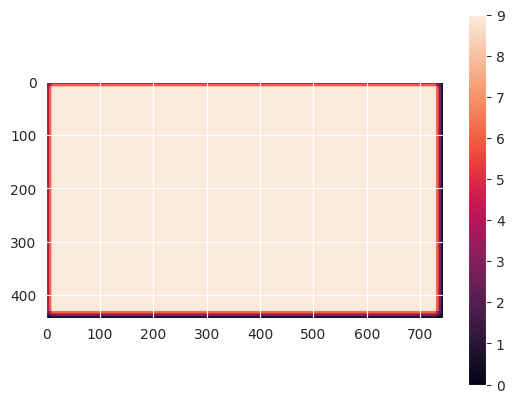

In [ ]:
N, cols_computed, rows_computed, mask = subregion_information(tile_predictions, val_rows, val_cols)

# Final Prediction

As explained before, since each fishnet tile appears in multiple sequences of images in the convLSTM, there are multiple predictions corresponding to that tile. Our goal is to combine this estimates, and come up with one unique urbanization rate prediction.

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error as mse

def performance(data, pred):
  print(f"mse = {mse(data, pred)} \n r2 = {r2_score(data, pred)}")

#### Approach 1)
Naive approach, assign equal weight to each prediction made by the convLSTM.

In [ ]:
pred_value = []
for i in range(len(tile_predictions)):
  pred_value.append(np.mean(tile_predictions[i]))

# apply the mask
pred_value = np.array(pred_value)[mask]

In [ ]:
# true value
data_value = val_data[val_data.year == 2022].urbanization_rate.reset_index(drop=True)[mask]

In [ ]:
performance(data_value, pred_value)

mse = 0.0012079193959777085 
 r2 = -0.004991194123729725


#### Approach 2)
Use XGB model to combine predictions. Each row corresponds to a tile. Features are


*   convLSTM predictions
*   urbanization in previous years
*   lat/long

The dependent variable is the urbanization rate.


In [ ]:
train_tile_pred = get_tile_predictions(y_ins_pred, train_rows, train_cols)
val_tile_pred = get_tile_predictions(y_pred, val_rows, val_cols)

IndexError: ignored

In [ ]:
N_train, cols_computed_train, rows_computed_train, mask_train = subregion_information(train_tile_pred, train_rows, train_cols, visualize = False)

ValueError: ignored

In [ ]:
tile_id_predicted = np.array(train_data[train_data.year == 2022].tile_id.reset_index(drop=True)[idx])

In [ ]:
tile_id_predicted

array(4879222)

In [ ]:
def create_dataset(data, tile_predictions, N = 9):
  # return id of tiles for which make prediction
  tile_id_predicted = np.array(data[data.year == 2022].tile_id.reset_index(drop=True)[idx])
  tile_pred_values = np.array([x for x in tile_predictions if len(x) == N])
  # create dataframe
  df = pd.DataFrame(data = tile_pred_values, index = tile_id_predicted, columns = [f"tile_{i+1}" for i in range(N)])

  # add absolute value urbanization value to the dataset
  for year in range(2017, 2021+1):
    df[f"{year}"] = data[data.year == year].urbanization.reset_index(drop = True)[idx].values

  # add Lat, Long
  df['Lat'] = data[data.year == 2022].Lat.reset_index(drop = True)[idx].values
  df['Lon'] = data[data.year == 2022].Lon.reset_index(drop = True)[idx].values

  return df


In [ ]:
X_train_xgb = create_dataset(train_data, train_tile_pred, N)

TypeError: ignored

<font color = 'red'> IMPROVE FROM HERE </font>

In [ ]:
df.head()

,tile_1,tile_2,tile_3,tile_4,tile_5,tile_6,tile_7,tile_8,tile_9,2017,2018,2019,2020,2021,Lat,Lon
4911917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.063912,-99.090344
4911918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.063912,-99.086324
4911919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.063912,-99.082304
4911920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.063912,-99.078284
4911921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.063912,-99.074263


In [ ]:
X = df.values
y = data_value.values

In [ ]:
# train test split
np.random.seed(42)
idx_selected = np.random.randint(0, len(y), size = int(len(y) * 0.8))

X_train, X_test = X[idx_selected], X[~idx_selected]
y_train, y_test = y[idx_selected], y[~idx_selected]


# from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [ ]:
# define XGboost model and fit
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
# evaluate performance on test
mse(y_test, y_pred)

0.0011167735884185805

In [ ]:
# compute r-squared
r2_score(y_test, y_pred)

0.34883142730593864

Text(0.5, 1.0, 'Feature Importance')

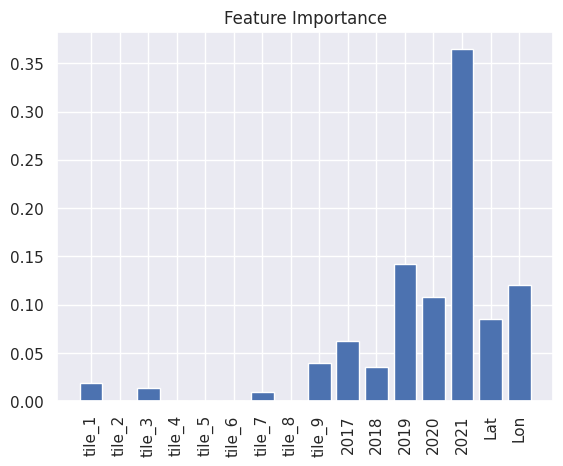

In [ ]:
# print feature importance
model.feature_importances_

# plot it
import matplotlib.pyplot as plt
# use seaborn
import seaborn as sns
sns.set()

# plot this with seaborn plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

# rename x-ticks with x_axis_names = df.columns
plt.xticks(range(len(model.feature_importances_)), df.columns, rotation = 90)

# title
plt.title('Feature Importance')


Text(0.5, 1.0, 'XGBoost Model')

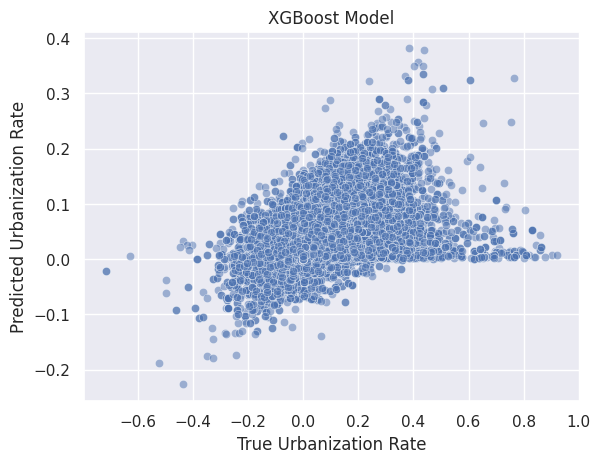

In [ ]:
# plot results
import seaborn as sns

# scatterplot with alpha
sns.scatterplot(x = y_test, y = y_pred, alpha = 0.5)
plt.xlabel('True Urbanization Rate')
plt.ylabel('Predicted Urbanization Rate')
plt.title('XGBoost Model')

For each tile, plot how well we are doing

In [ ]:
tile_error = np.zeros(len(y))

In [ ]:
tile_error[idx_selected] = (y_test - y_pred) ** 2

<Axes: >

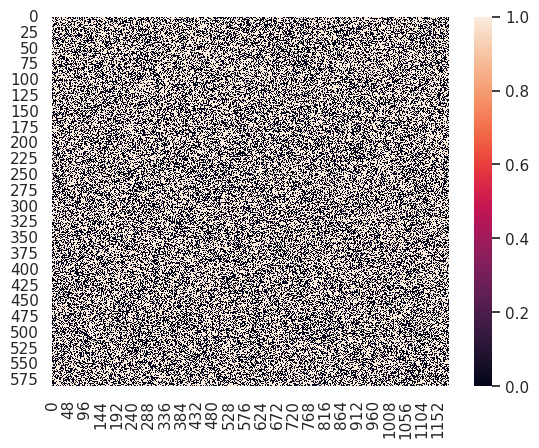

In [ ]:
sns.heatmap(np.where(tile_error > 0, 1, 0).reshape(rows_computed,cols_computed))

In [ ]:
tile_error = np.log(tile_error).reshape(rows_computed, cols_computed)

<Axes: >

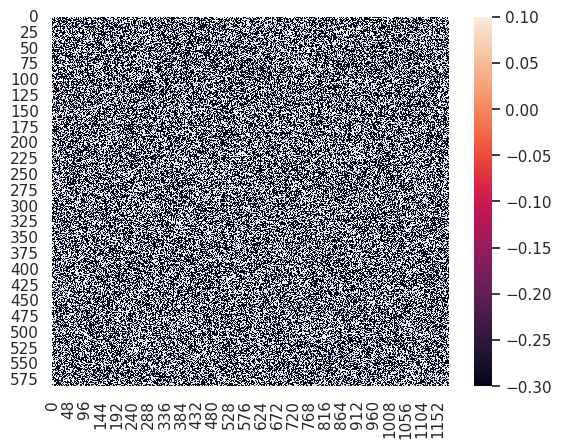

In [ ]:
import seaborn as sns

sns.heatmap(tile_error)

In [ ]:
585*1185

693225

### Benchmark

Predicting that nothing is urbanized

In [ ]:
fill_value = 0
avg_urbanization = [fill_value for i in range(len(y_val_flat))]


In [ ]:
r2_score(y_val_flat, avg_urbanization)

-0.18836083241983226

In [ ]:
from sklearn.metrics import mean_squared_error as mse
mse(y_val_flat, avg_urbanization)


0.07176679055762618